In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.utils import resample
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
sns.set()

In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
# import raw data file
path = 'C:/Users/tobymasters/Dropbox/Education/IBM Data Science Certification/Capstone Project/Data/Full Dataset/'
raw_data = pd.read_csv(path + 'Collisions.csv')
raw_data.shape

(221389, 40)

In [4]:
# extract important features
features = ['SEVERITYCODE', 'ADDRTYPE', 'INATTENTIONIND', 'UNDERINFL',
           'WEATHER', 'ROADCOND', 'LIGHTCOND', 'SPEEDING', 'PEDCOUNT', 'PEDCYLCOUNT']
data = raw_data[features]
data.iloc[0]

SEVERITYCODE                            1
ADDRTYPE                            Block
INATTENTIONIND                        NaN
UNDERINFL                               N
WEATHER                           Raining
ROADCOND                              Wet
LIGHTCOND         Dark - Street Lights On
SPEEDING                              NaN
PEDCOUNT                                0
PEDCYLCOUNT                             0
Name: 0, dtype: object

In [5]:
# transform target variable for binary classification
data.SEVERITYCODE = data.SEVERITYCODE.replace({'0':0, '1':0, '2':1, '2b':1, '3':1}).copy()
data.SEVERITYCODE.value_counts()

C:\Users\tobymasters\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


0.0    159190
1.0     62198
Name: SEVERITYCODE, dtype: int64

In [6]:
# clean mixed type data
data.UNDERINFL = data.UNDERINFL.replace({'Y': 1, 'N': 0, '1': 1, '0': 0})

# convert data to binary
data[['SPEEDING', 'INATTENTIONIND']] = data[['SPEEDING', 'INATTENTIONIND']].replace(np.nan, 0).copy()
data[['SPEEDING', 'INATTENTIONIND']] = data[['SPEEDING', 'INATTENTIONIND']].replace('Y', 1).copy()
data.ADDRTYPE = data.ADDRTYPE.replace({'Alley':np.nan, 'Block':0, 'Intersection':1}).copy()

# remove 'Unknown' classifications
data = data.replace('Unknown', np.nan).copy()

# create pedestrial/cyclist indicator feature
data['PEDCYL'] = (data.PEDCOUNT + data.PEDCYLCOUNT > 0).astype(int)

C:\Users\tobymasters\Anaconda3\lib\site-packages\pandas\core\frame.py:3494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [7]:
# assess null value counts
data.isnull().sum().to_frame()

,0
SEVERITYCODE,1
ADDRTYPE,4588
INATTENTIONIND,0
UNDERINFL,26210
WEATHER,41551
ROADCOND,41478
LIGHTCOND,40041
SPEEDING,0
PEDCOUNT,0
PEDCYLCOUNT,0


In [8]:
# drop observations with null values
data.dropna(axis=0, inplace=True)
data.isnull().sum().to_frame()

,0
SEVERITYCODE,0
ADDRTYPE,0
INATTENTIONIND,0
UNDERINFL,0
WEATHER,0
ROADCOND,0
LIGHTCOND,0
SPEEDING,0
PEDCOUNT,0
PEDCYLCOUNT,0


In [9]:
data.shape

(174425, 11)

In [10]:
# one-hot encode WEATHER
weather = pd.get_dummies(data.WEATHER)
weather.columns = ['sand_dirt', 'clear', 'fog_smoke', 'other_w', 'overcast', 'partly_cloudy', 'raining', 'crosswind', 'sleet', 'snowing']
weather.head()

,sand_dirt,clear,fog_smoke,other_w,overcast,partly_cloudy,raining,crosswind,sleet,snowing
0,0,0,0,0,0,0,1,0,0,0
1,0,1,0,0,0,0,0,0,0,0
5,0,1,0,0,0,0,0,0,0,0
6,0,1,0,0,0,0,0,0,0,0
8,0,0,0,0,1,0,0,0,0,0


In [11]:
# one-hot encode LIGHTCOND
light = pd.get_dummies(data.LIGHTCOND)
light.columns = ['dark_no_lights', 'dark_lights_off', 'dark_lights_on', 'dark_unknown', 'dawn', 'daylight', 'dusk', 'other_l']
light.head()

,dark_no_lights,dark_lights_off,dark_lights_on,dark_unknown,dawn,daylight,dusk,other_l
0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,1,0,0
5,0,0,0,0,0,1,0,0
6,0,0,0,0,0,1,0,0
8,0,0,0,0,0,1,0,0


In [12]:
# one-hot encode ROADCOND
road = pd.get_dummies(data.ROADCOND)
road.columns = ['dry', 'ice', 'oil', 'other_r', 'sand', 'snow', 'st_water', 'wet']
road.head()

,dry,ice,oil,other_r,sand,snow,st_water,wet
0,0,0,0,0,0,0,0,1
1,1,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,1
8,1,0,0,0,0,0,0,0


In [13]:
# rebuild dataset with encoded features
data = data[['SEVERITYCODE', 'ADDRTYPE', 'INATTENTIONIND', 'UNDERINFL', 'SPEEDING', 'PEDCYL']]
data.columns = ['severity', 'addr_type', 'inattention_ind', 'under_infl', 'speeding', 'ped_cyl']
data = pd.concat([data, weather, light, road], axis=1).astype(int)
data.head()

,severity,addr_type,inattention_ind,under_infl,speeding,ped_cyl,sand_dirt,clear,fog_smoke,other_w,...,dusk,other_l,dry,ice,oil,other_r,sand,snow,st_water,wet
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
6,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
8,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [14]:
data.shape

(174425, 32)

In [15]:
# build summary table of inferential testing
from scipy import stats
statistics = data.sum().to_frame()
statistics.columns = ['collisions']
for feature in statistics.index:
    statistics.loc[feature, 'injury_perc'] = data[data[feature]==1].severity.mean()
    pc = stats.pearsonr(data.severity, data[feature])
    statistics.loc[feature, 'corr'] = pc[0]
    statistics.loc[feature, 'p_val'] = pc[1]

In [16]:
# sort and display table
statistics.sort_values('corr', ascending=False, inplace=True)
statistics.round(4)

,collisions,injury_perc,corr,p_val
severity,59626,1.0000,1.0000,0.0000
ped_cyl,13412,0.9035,0.3418,0.0000
addr_type,63791,0.4525,0.1771,0.0000
under_infl,9428,0.4236,0.0412,0.0000
speeding,9653,0.4111,0.0353,0.0000
daylight,115250,0.3506,0.0258,0.0000
inattention_ind,28826,0.3674,0.0240,0.0000
raining,33393,0.3519,0.0103,0.0000
wet,47400,0.3480,0.0079,0.0010
dusk,5781,0.3520,0.0040,0.0973


Text(0, 0.5, 'Correlation')

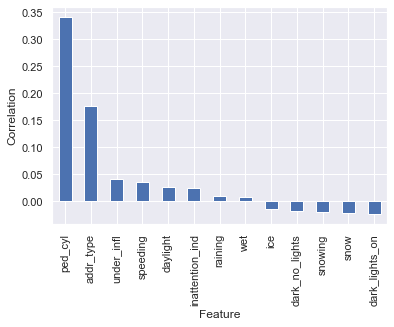

In [17]:
# plot statistically significant Pearson correlations
statistics[statistics.p_val < 0.001]['corr'].iloc[1:].plot.bar()
plt.xlabel('Feature')
plt.ylabel('Correlation')

In [56]:
# split data into training and test sets
X = data.iloc[:, 1:]
y = data.iloc[:, 0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)
X_train.shape, y_train.shape

((122097, 31), (122097,))

DecisionTrees's Accuracy:  0.721
DecisionTrees's F1 Score:  0.659
Normalized confusion matrix
[[0.984 0.016]
 [0.785 0.215]]


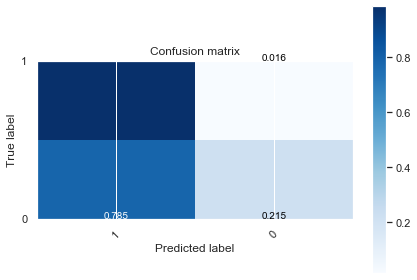

In [58]:
# test decision tree on unbalanced data for benchmark
accidentTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
accidentTree.fit(X_train,y_train)
yhat = accidentTree.predict(X_test)
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, yhat).round(3))
print("DecisionTrees's F1 Score: ", metrics.f1_score(y_test, yhat, average='weighted').round(3))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[1, 0],normalize= True,  title='Confusion matrix')

In [46]:
# rebalance target with upsampling
# Separate majority and minority classes
df_minority = data[data.severity==1]
df_majority = data[data.severity==0]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=114799,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.severity.value_counts()

1    114799
0    114799
Name: severity, dtype: int64

In [47]:
# rebalance target with downsampling
# Separate majority and minority classes
df_minority = data[data.severity==1]
df_majority = data[data.severity==0]
 
# Upsample minority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,     # sample with replacement
                                 n_samples=59626,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_downsampled = pd.concat([df_minority, df_majority_downsampled])
 
# Display new class counts
df_downsampled.severity.value_counts()

1    59626
0    59626
Name: severity, dtype: int64

Upsampled DecisionTrees's Accuracy:  0.628
Upsampled DecisionTrees's F1 Score:  0.628
Normalized confusion matrix
[[0.651 0.349]
 [0.395 0.605]]


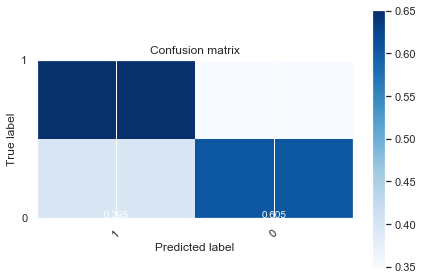

In [48]:
# test upsampled decision tree
X = df_upsampled.iloc[:, 1:]
y = df_upsampled.iloc[:, 0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)
accidentTree = DecisionTreeClassifier(criterion="entropy", max_depth = 3)
accidentTree.fit(X_train,y_train)
yhat = accidentTree.predict(X_test)

print("Upsampled DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, yhat).round(3))
print("Upsampled DecisionTrees's F1 Score: ", metrics.f1_score(y_test, yhat, average='weighted').round(3))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat)
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[1, 0],normalize= True,  title='Confusion matrix')

Upsampled DecisionTrees's Accuracy:  0.629
Upsampled DecisionTrees's F1 Score:  0.629
Normalized confusion matrix
[[0.657 0.343]
 [0.398 0.602]]


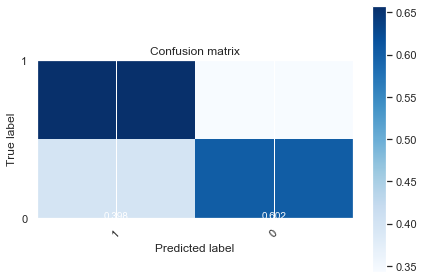

In [49]:
# test downsampled decision tree
X = df_downsampled.iloc[:, 1:]
y = df_downsampled.iloc[:, 0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)
accidentTree = DecisionTreeClassifier(criterion="entropy", max_depth = 3)
accidentTree.fit(X_train,y_train)
yhat = accidentTree.predict(X_test)

print("Upsampled DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, yhat).round(3))
print("Upsampled DecisionTrees's F1 Score: ", metrics.f1_score(y_test, yhat, average='weighted').round(3))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat)
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[1, 0],normalize= True,  title='Confusion matrix')

Text(0, 0.5, 'Accuracy')

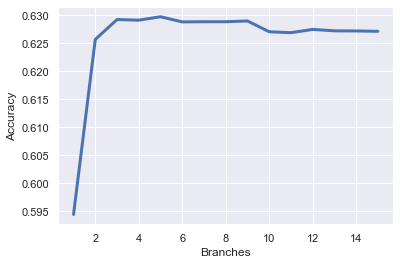

In [50]:
# test sensitivity of max branches
max_branch = 15
acc = np.zeros(max_branch + 1)
for max_depth in range(1, max_branch + 1):
    accTree = DecisionTreeClassifier(criterion="entropy", max_depth = max_depth)
    accTree.fit(X_train,y_train)
    predTree = accTree.predict(X_test)
    acc[max_depth] = metrics.accuracy_score(y_test, predTree)
plt.plot(range(1, max_branch + 1), acc[1:], lw=3)
plt.xlabel('Branches')
plt.ylabel('Accuracy')

Upsampled DecisionTrees's Accuracy:  0.63
Upsampled DecisionTrees's F1 Score:  0.629
Normalized confusion matrix
[[0.679 0.321]
 [0.419 0.581]]


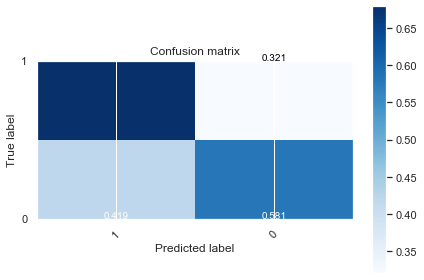

In [51]:
# compute metrics for optimal tree
accidentTree = DecisionTreeClassifier(criterion="entropy", max_depth = 5)
accidentTree.fit(X_train,y_train)
yhat = accidentTree.predict(X_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, predTree)
np.set_printoptions(precision=2)

print("Upsampled DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, yhat).round(3))
print("Upsampled DecisionTrees's F1 Score: ", metrics.f1_score(y_test, yhat, average='weighted').round(3))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat)
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[1, 0],normalize= True,  title='Confusion matrix')

Upsampled DecisionTrees's Accuracy:  0.629
Upsampled DecisionTrees's F1 Score:  0.629
Normalized confusion matrix
[[0.657 0.343]
 [0.398 0.602]]


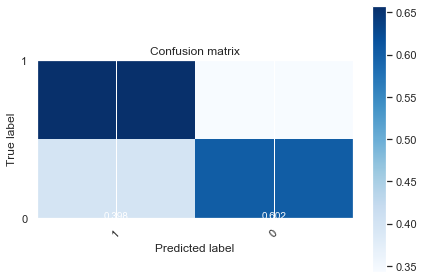

In [52]:
# compute metrics for preferred tree
accidentTree = DecisionTreeClassifier(criterion="entropy", max_depth = 3)
accidentTree.fit(X_train,y_train)
yhat = accidentTree.predict(X_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, predTree)
np.set_printoptions(precision=2)

print("Upsampled DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, yhat).round(3))
print("Upsampled DecisionTrees's F1 Score: ", metrics.f1_score(y_test, yhat, average='weighted').round(3))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat)
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[1, 0],normalize= True,  title='Confusion matrix')

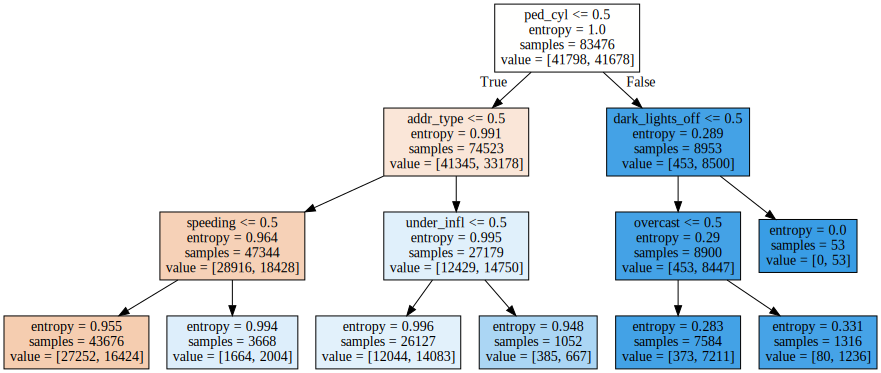

In [53]:
# visualise 3 branch tree
import graphviz
from IPython.display import SVG
from sklearn.tree import export_graphviz
dot_data = export_graphviz(accidentTree, out_file=None, feature_names=X.columns, filled=True) 
graph = graphviz.Source(dot_data) 
png = graph.pipe(format='png')
with open(path + 'dtree_pipe.png','wb') as f:
    f.write(png)
graph

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 

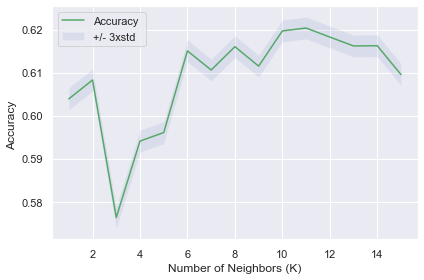

In [54]:
# test sensitive of k for KNN classfier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

Ks = 15
mean_acc = np.zeros((Ks))
std_acc = np.zeros((Ks))
ConfustionMx = [];
for n in range(1, Ks+1):
    print(n, end=' ')
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

plt.plot(range(1,Ks + 1),mean_acc,'g')
plt.fill_between(range(1,Ks + 1),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

KNN Accuracy:  0.62
KNN F1 Score:  0.616
Normalized confusion matrix
[[0.722 0.278]
 [0.480 0.520]]


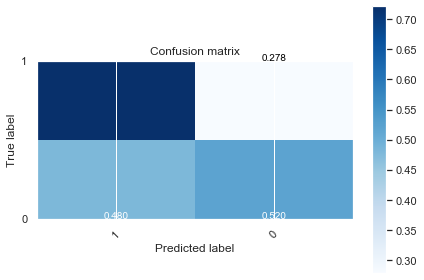

In [55]:
# compute metrics for optimal k
k = 11
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
yhat = neigh.predict(X_test)

print("KNN Accuracy: ", metrics.accuracy_score(y_test, yhat).round(3))
print("KNN F1 Score: ", metrics.f1_score(y_test, yhat, average='weighted').round(3))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat)
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[1, 0],normalize= True,  title='Confusion matrix')

In [31]:
# test for optimal kernal model for SVM
from sklearn import svm
for kernal in ['linear', 'rbf', 'sigmoid', 'poly']:
    clf = svm.SVC(kernel=kernal, gamma='auto')
    clf.fit(X_train, y_train) 
    yhat = clf.predict(X_test)
    print(kernal, ': ', metrics.f1_score(y_test, yhat, average='weighted').round(3)
         
         )

linear :  0.6238175075733724
rbf :  0.6289998622363138
sigmoid :  0.5927188285630786
poly :  0.6089519072600539


In [32]:
# test for optimal c for SVM
for c in [1000, 100, 10, 1, 0.1, 0.01]:
    clf = svm.SVC(kernel='rbf', C=c, gamma='auto')
    clf.fit(X_train, y_train) 
    yhat = clf.predict(X_test)
    print(c, ': ', metrics.f1_score(y_test, yhat, average='weighted').round(3))

1000 :  0.628
100 :  0.628
10 :  0.629
1 :  0.629
0.1 :  0.624
0.01 :  0.624


SVM Accuracy:  0.629
SVM F1 Score:  0.629
Normalized confusion matrix
[[0.657 0.343]
 [0.398 0.602]]


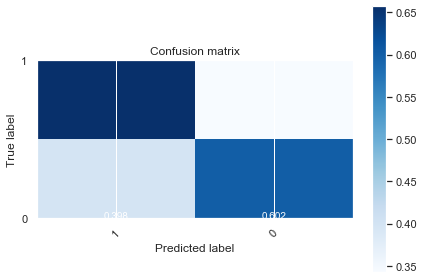

In [40]:
# compute metrics for optimal SVM
from sklearn import svm
clf = svm.SVC(kernel='rbf', C=1, gamma='auto')
clf.fit(X_train, y_train) 
yhat = clf.predict(X_test)

print("SVM Accuracy: ", metrics.accuracy_score(y_test, yhat).round(3))
print("SVM F1 Score: ", metrics.f1_score(y_test, yhat, average='weighted').round(3))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[1, 0],normalize= True,  title='Confusion matrix')

In [38]:
# test for optimal c in Logistic Regression
from sklearn.linear_model import LogisticRegression
for c in [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]:
    LR = LogisticRegression(C=c, solver='liblinear').fit(X_train,y_train)
    yhat = LR.predict(X_test)
    print(c, metrics.accuracy_score(y_test, yhat).round(3), metrics.f1_score(y_test, yhat, average='weighted').round(3))

0.0001 0.626 0.624
0.001 0.628 0.626
0.01 0.628 0.625
0.1 0.627 0.624
1 0.627 0.624
10 0.627 0.624
100 0.627 0.624


Logistic Regression Accuracy:  0.628
Logistic Regression F1 Score:  0.626
Normalized confusion matrix
[[0.691 0.309]
 [0.435 0.565]]


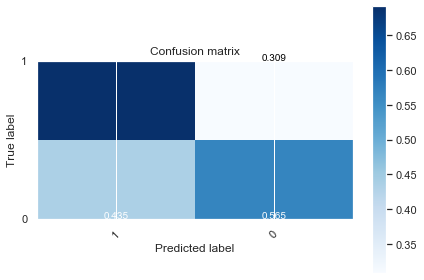

In [35]:
# compute metrics for optimal LR model
LR = LogisticRegression(C=0.001, solver='liblinear').fit(X_train,y_train)
yhat = LR.predict(X_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat)
np.set_printoptions(precision=2)

print("Logistic Regression Accuracy: ", metrics.accuracy_score(y_test, yhat).round(3))
print("Logistic Regression F1 Score: ", metrics.f1_score(y_test, yhat, average='weighted').round(3))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[1, 0],normalize= True,  title='Confusion matrix')